# WGAN-GP

元論文 : Improved Training of Wasserstein GANs https://arxiv.org/abs/1704.00028 (2017)

### 論文のサマリ 

WGANのパラメータのクリッピングは最適化を難しくするというのがWGAN-GPの導入背景。
Critic(DiscriminatorをWGANの論文ではCriticと呼ぶ)にBatch Normalizationが入っているとパラメータのクリッピング問題は弱めることができるけど、深いCriticでは収束しにくいらしい。

Criticのパラメータを[-c, c]にクリッピングするが、cの値を注意深く選ばないと勾配消失か勾配爆発になってしまう。しかし、WGANでWasserstain距離を用いた画像でLossを作るために1Lipschits制約を実現するために、このクリッピングが必要だった。

なので、**WGAN-GPでは勾配を1に近づける正則化項（=GP : Gradient Penalty) を導入することで、クリッピングを行わずに1Lipschits制約を実現する。**

ただし、BatchNormalizationはバッチで正規化するけど、GPは入力毎に行うので、相性が悪い。CriticではBatchNormalizationの代わりにLayerNormalizationを入れた。(これで結果も良くなった)

以上がWGAN-GPの論文での主張

DCGAN, LSGAN, WGAN, WGAN-GPを比較するために、GeneratorとDiscriminatorにいろんな条件をつけて LSUNデータセットで試した。その結果がFigure.2。WGAN-GPがずば抜けていい画像を作っている。しかもRes101をGとDに使ってもモード崩壊に陥らないという。

### アルゴリズム

WGAN-GPのアルゴリズムは、イテレーション毎に以下のDiscriminatorとGeneratorの学習を交互に行っていく。
- 最適化 : Adam (LearningRate: 0.0001, β1=0, β2=0.9)
- λ = 10

アルゴリズム

#### Discriminatorの学習(以下をcriticの回数だけ繰り返す）

1. ノイズzをサンプリングし、 $G_z = G(z)$ を求める
2. $\epsilon \in [0, 1]$ をランダムに選び、Realデータ$X$ と　$G_z$ の重み付き平均 $\hat{x} = \epsilon X + (1 - \epsilon) G_z$ を計算する
3. Loss $L^i = D(G_z) - D(X) + \lambda (\| \nabla_{\hat{x}} D(\hat{x}) \|_2 - 1)^2$　を計算し、SGD

#### Generatorの学習

1. ノイズzをサンプリングして、 Loss $L = \frac{1}{|Minibatch|} \sum_{i} - D(G(z))$ を計算し、SGD

GeneratorとDiscriminatorの構造は次の通り。WGAN-GPではResBlock構造を導入して、Deepな構造にしている。

#### Generator

ResNetの活性化関数はReLU

<img src='https://github.com/yoyoyo-yo/DeepLearningMugenKnock/blob/master/Scripts_Generative/assets/WGAN-gp_D.png' width=600>

#### Discriminator

ResNetの活性化関数はLeakyReLU(0.2)

<img src='https://github.com/yoyoyo-yo/DeepLearningMugenKnock/blob/master/Scripts_Generative/assets/WGAN-gp_D.png' width=600>

それぞれにおいてResBlockは以下の構造となる

#### ResBlock

<img src='../assets/WGAN-gp_ResBlock.png' width=300>

## Import and Config

In [1]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from _main_base import *

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = ['akahara', 'madara'] # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_Z_DIM = 128
cfg.INPUT_MODE = None

cfg.OUTPUT_HEIGHT = 64
cfg.OUTPUT_WIDTH = 64
cfg.OUTPUT_CHANNEL = 3
cfg.OUTPUT_MODE = 'RGB'  # RGB, GRAY, EDGE, CLASS_LABEL

cfg.G_DIM = 64
cfg.D_DIM = 64

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = False
cfg.DEVICE = torch.device('cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu')

# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'WGAN-GP'
cfg.TRAIN.MODEL_G_SAVE_PATH = 'models/' + cfg.PREFIX + '_G_{}.pt'
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 200
cfg.TRAIN.ITERATION = 10_000
cfg.TRAIN.MINIBATCH = 32
cfg.TRAIN.OPTIMIZER_G = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_G = {'lr' : 0.0001, 'betas' : (0., 0.9)}
cfg.TRAIN.OPTIMIZER_D = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_D = {'lr' : 0.0001, 'betas' : (0., 0.9)}
cfg.TRAIN.LOSS_FUNCTION = None

cfg.TRAIN.DATA_PATH = '../../Dataset/train/images/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = True # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = False # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = False # data augmentation : rotation False, or integer

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'

#---
# WGAN  config
#---
cfg.TRAIN.WGAN_CRITIC_N = 5
cfg.TRAIN.WGAN_GP_LAMBDA = 10

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_G_PATH = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = '../../Dataset/test/images/'
cfg.TEST.MINIBATCH = 10
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_G_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)


## Define Model

In [2]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

class Reshape(torch.nn.Module):
    def __init__(self, c, h, w):
        super(Reshape, self).__init__()
        self.c = c
        self.h = h
        self.w = w
    
    def forward(self, x):
        x = x.view(x.size()[0], self.c, self.h, self.w)
        return x
    
    
# ResNet block
class ResBlock(torch.nn.Module):
    def __init__(self, dim_first=None, dim=128, activation_fn=torch.nn.ReLU(), batch_norm=False, name=''):
        super(ResBlock, self).__init__()

        if dim_first is None:
            dim_first = dim
        else:
            if batch_norm:
                self.skip_conv = torch.nn.Sequential(OrderedDict({
                    name + '_skip_bn' : torch.nn.BatchNorm2d(dim_first),
                    name + '_skip_activation' : activation_fn,
                    name + '_skip_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1)
                }))
            else:
                self.skip_conv = torch.nn.Sequential(OrderedDict({
                    name + '_skip_activation' : activation_fn,
                    name + '_skip_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1)
                }))
        
        if batch_norm:
            self.block = torch.nn.Sequential(OrderedDict({
                name + '_layer_1_bn' : torch.nn.BatchNorm2d(dim_first),
                name + '_layer_1_activation' : activation_fn,
                name + '_layer_1_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1),
                name + '_layer_2_bn' : torch.nn.BatchNorm2d(dim),
                name + '_layer_2_activation' : activation_fn,
                name + '_layer_2_conv' : torch.nn.Conv2d(dim, dim, kernel_size=3, padding=1, stride=1)
            }))
        else:
            self.block = torch.nn.Sequential(OrderedDict({
                name + '_layer_1_activation' : activation_fn,
                name + '_layer_1_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1),
                name + '_layer_2_activation' : activation_fn,
                name + '_layer_2_conv' : torch.nn.Conv2d(dim, dim, kernel_size=3, padding=1, stride=1)
            }))


    def forward(self, x):
        res_x = self.block(x)

        if hasattr(self, 'skip_conv'):
            x = self.skip_conv(x)
        
        x = torch.add(res_x, x)
        x = F.relu(x)
        return x
        
    
class Generator(torch.nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            'G_layer_1' : torch.nn.Linear(cfg.INPUT_Z_DIM, cfg.G_DIM * (cfg.OUTPUT_HEIGHT // 8) * (cfg.OUTPUT_WIDTH // 8)),
            'G_layer_1_reshape' : Reshape(cfg.G_DIM, cfg.OUTPUT_HEIGHT // 8, cfg.OUTPUT_HEIGHT // 8),
            'G_layer_1_bn' : torch.nn.BatchNorm2d(cfg.G_DIM),
            'G_layer_1_activation' : torch.nn.ReLU(),     
            
            'G_layer_2_resBlock' : ResBlock(dim=cfg.G_DIM, activation_fn=torch.nn.ReLU(), batch_norm=True, name='G_resBlock_1'),
            'G_layer_2_upsampling' : torch.nn.UpsamplingBilinear2d(scale_factor=2),
            
            'G_layer_3_resBlock' : ResBlock(dim=cfg.G_DIM, activation_fn=torch.nn.ReLU(), batch_norm=True, name='G_resBlock_2'),
            'G_layer_3_upsampling' : torch.nn.UpsamplingBilinear2d(scale_factor=2),
            
            'G_layer_4_resBlock' : ResBlock(dim=cfg.G_DIM, activation_fn=torch.nn.ReLU(), batch_norm=True, name='G_resBlock_3'),
            'G_layer_4_upsampling' : torch.nn.UpsamplingBilinear2d(scale_factor=2),
        
            'G_layer_out' : torch.nn.Conv2d(cfg.G_DIM, cfg.OUTPUT_CHANNEL, kernel_size=3, stride=1, padding=1),
            'G_layer_out_activation' : torch.nn.Tanh(),
        }))
        
    def forward(self, x):
        x = self.module(x)
        return x


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()    
        self.module = torch.nn.Sequential(OrderedDict({
            'D_layer_1_resBlock' : ResBlock(dim_first=cfg.OUTPUT_CHANNEL, dim=cfg.D_DIM, activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_1'),
            'D_layer_1_pool' : torch.nn.AvgPool2d(2, stride=2),

            'D_layer_2_resBlock' : ResBlock(dim=cfg.D_DIM, activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_2'),
            'D_layer_2_pool' : torch.nn.AvgPool2d(2, stride=2),

            'D_layer_3_resBlock' : ResBlock(dim=cfg.D_DIM, activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_3'),

            'D_layer_4_resBlock' : ResBlock(dim=cfg.D_DIM, activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_4'),
            'D_layer_4_activation' : torch.nn.ReLU(),

            'D_layer_5_pool' : torch.nn.AdaptiveAvgPool2d((1, 1)),
            'D_layer_5_flatten' : Flatten(),
            'D_layer_out' : torch.nn.Linear(cfg.D_DIM, 1),
        }))

    def forward(self, x):
        x = self.module(x)
        return x
    
    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('bn') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

## Train

100%|██████████| 16/16 [00:00<00:00, 14979.66it/s]

Dataset >> ../../Dataset/train/images/
 - Found data num >> 16
 - Horizontal >> True
 - Vertical >> False
 - Rotation >> False
all data num >> 32
dataset was completely loaded
--
training start


Iter:50, LossG (fake:507.5220), LossD:1069.6210 (real:-498.2992, fake:564.2363), WDistance:-1062.5355, GP:7.0854
Iter:100, LossG (fake:104549.4531), LossD:132734.3438 (real:1062.6798, fake:115208.6172), WDistance:-114145.9375, GP:18588.4141
Iter:150, LossG (fake:130505.1016), LossD:106181.2031 (real:61997.8711, fake:153288.8125), WDistance:-91290.9375, GP:14890.2627
Iter:200, LossG (fake:465574.1562), LossD:155950.3438 (real:266945.8750, fake:368616.0312), WDistance:-101670.1562, GP:54280.1914
save G >> models/WGAN-GP_G_iter200.pt, D >> models/WGAN-GP_D_iter200.pt
Iter:250, LossG (fake:162942.9844), LossD:130690.5312 (real:98518.4297, fake:202278.4062), WDistance:-103759.9766, GP:26930.5586
Iter:300, LossG (fake:105479.2969), LossD:119116.4219 (real:34359.5547, fake:122756.1172), WDistance:-88396.5625, GP:30719.8633
Iter:350, LossG (fake:169828.6875), LossD:155282.1562 (real:65047.8984, fake:161362.4062), WDistance:-96314.5078, GP:58967.6562
Iter:400, LossG (fake:25749.4922), LossD:140

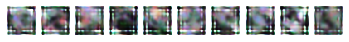

Iter:550, LossG (fake:193972.3750), LossD:132304.6406 (real:128739.4609, fake:221636.3750), WDistance:-92896.9141, GP:39407.7266
Iter:600, LossG (fake:114849.2344), LossD:117820.5781 (real:36556.9766, fake:108288.6719), WDistance:-71731.6953, GP:46088.8867
save G >> models/WGAN-GP_G_iter600.pt, D >> models/WGAN-GP_D_iter600.pt
Iter:650, LossG (fake:175292.0000), LossD:97166.4844 (real:85290.7578, fake:149362.2500), WDistance:-64071.4922, GP:33094.9922
Iter:700, LossG (fake:111231.7578), LossD:86472.1094 (real:35534.2656, fake:92686.2734), WDistance:-57152.0078, GP:29320.0996
Iter:750, LossG (fake:7834.9634), LossD:77206.6719 (real:-28206.7891, fake:36159.9102), WDistance:-64366.6992, GP:12839.9697
Iter:800, LossG (fake:169473.6875), LossD:76091.7500 (real:111694.6328, fake:162475.8906), WDistance:-50781.2578, GP:25310.4961
save G >> models/WGAN-GP_G_iter800.pt, D >> models/WGAN-GP_D_iter800.pt
Iter:850, LossG (fake:40197.3477), LossD:79090.0156 (real:-29669.1113, fake:20253.1406), WDis

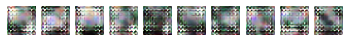

Iter:1050, LossG (fake:-46050.8438), LossD:100349.6484 (real:-143405.6250, fake:-85022.6953), WDistance:-58382.9297, GP:41966.7188
Iter:1100, LossG (fake:-9063.9814), LossD:91096.4375 (real:-94792.0312, fake:-40315.2344), WDistance:-54476.7969, GP:36619.6406
Iter:1150, LossG (fake:52612.8789), LossD:76953.9375 (real:-25600.7285, fake:19365.4004), WDistance:-44966.1289, GP:31987.8105
Iter:1200, LossG (fake:-15055.3682), LossD:92512.5156 (real:-87474.1875, fake:-26884.0781), WDistance:-60590.1094, GP:31922.4102
save G >> models/WGAN-GP_G_iter1200.pt, D >> models/WGAN-GP_D_iter1200.pt
Iter:1250, LossG (fake:28229.0625), LossD:77765.9844 (real:-46442.3438, fake:360.6844), WDistance:-46803.0273, GP:30962.9570
Iter:1300, LossG (fake:82417.8906), LossD:76218.9062 (real:10166.5117, fake:56339.9531), WDistance:-46173.4414, GP:30045.4688
Iter:1350, LossG (fake:104444.8984), LossD:64554.9922 (real:30173.3145, fake:72575.1875), WDistance:-42401.8750, GP:22153.1172
Iter:1400, LossG (fake:20384.8828

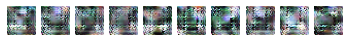

Iter:1550, LossG (fake:-25176.3145), LossD:60513.1641 (real:-77926.7656, fake:-40907.4375), WDistance:-37019.3281, GP:23493.8359
Iter:1600, LossG (fake:21832.1680), LossD:45221.4336 (real:-4217.3574, fake:27591.9082), WDistance:-31809.2656, GP:13412.1689
save G >> models/WGAN-GP_G_iter1600.pt, D >> models/WGAN-GP_D_iter1600.pt
Iter:1650, LossG (fake:-45448.3125), LossD:72742.1875 (real:-141379.2812, fake:-98047.3906), WDistance:-43331.8906, GP:29410.2930
Iter:1700, LossG (fake:-81339.6328), LossD:52614.8438 (real:-96120.0312, fake:-56658.4766), WDistance:-39461.5547, GP:13153.2900
Iter:1750, LossG (fake:-43407.3477), LossD:36457.8438 (real:-24990.0977, fake:4826.1133), WDistance:-29816.2109, GP:6641.6338
Iter:1800, LossG (fake:-24867.1289), LossD:39974.0156 (real:-10231.5312, fake:20050.0039), WDistance:-30281.5352, GP:9692.4785
save G >> models/WGAN-GP_G_iter1800.pt, D >> models/WGAN-GP_D_iter1800.pt
Iter:1850, LossG (fake:-2174.0942), LossD:46643.9336 (real:-38772.0156, fake:-8323.50

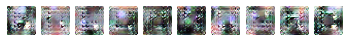

Iter:2050, LossG (fake:-22967.6348), LossD:38048.7266 (real:-28194.3320, fake:-641.6205), WDistance:-27552.7109, GP:10496.0176
Iter:2100, LossG (fake:44030.6406), LossD:43916.1875 (real:-1084.4290, fake:27803.4043), WDistance:-28887.8340, GP:15028.3545
Iter:2150, LossG (fake:-18895.6660), LossD:42148.0234 (real:-33798.8672, fake:-4274.5312), WDistance:-29524.3359, GP:12623.6855
Iter:2200, LossG (fake:-3203.6450), LossD:47254.0156 (real:-58275.5859, fake:-28759.5508), WDistance:-29516.0352, GP:17737.9824
save G >> models/WGAN-GP_G_iter2200.pt, D >> models/WGAN-GP_D_iter2200.pt
Iter:2250, LossG (fake:9757.5078), LossD:50444.5312 (real:-64382.4883, fake:-32286.7148), WDistance:-32095.7734, GP:18348.7578
Iter:2300, LossG (fake:-78964.0000), LossD:39972.4688 (real:-92203.2578, fake:-62810.1172), WDistance:-29393.1406, GP:10579.3281
Iter:2350, LossG (fake:10266.4102), LossD:35994.6953 (real:-15712.3750, fake:9814.0684), WDistance:-25526.4434, GP:10468.2520
Iter:2400, LossG (fake:-46435.1680)

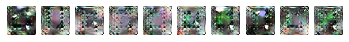

|||

In [ ]:
def result_show(G, z, path=None, save=False, show=False):
    if (save or show) is False:
        print('argument save >> {} and show >> {}, so skip')
        return

    Gz = G(z)
    Gz = Gz.detach().cpu().numpy()

    Gz = (Gz * 127.5 + 127.5).astype(np.uint8)
    Gz = Gz.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])
    Gz = Gz.transpose(0, 2, 3, 1)

    for i in range(cfg.TEST.MINIBATCH):
        _G = Gz[i]
        plt.subplot(1, cfg.TEST.MINIBATCH, i + 1)
        plt.imshow(_G)
        plt.axis('off')

    if path is not None:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()

# train
def train():
    # model
    G = Generator().to(cfg.DEVICE)
    D = Discriminator().to(cfg.DEVICE)
    
    G.apply(weights_init)
    D.apply(weights_init)

    opt_G = cfg.TRAIN.OPTIMIZER_G(G.parameters(), **cfg.TRAIN.LEARNING_PARAMS_G)
    opt_D = cfg.TRAIN.OPTIMIZER_D(D.parameters(), **cfg.TRAIN.LEARNING_PARAMS_D)

    path_dict = data_load(cfg)
    paths = path_dict['paths']
    paths_gt = path_dict['paths_gt']

    # training
    mbi = 0
    train_N = len(paths)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss_G = []
    list_loss_D = []
    list_loss_D_real = []
    list_loss_D_fake = []
    list_loss_WDistance = []
    list_loss_GP = []

    one = torch.FloatTensor([1])
    minus_one = one * -1

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        # update D
        for _ in range(cfg.TRAIN.WGAN_CRITIC_N):
            opt_D.zero_grad()

            # sample X
            Xs = torch.tensor(get_image(paths[mb_ind], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)

            # sample x
            z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM))
            z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

            # forward
            Gz = G(z)
            loss_D_fake = D(Gz).mean(0).view(1)
            loss_D_real = D(Xs).mean(0).view(1)
            
            #---
            # Gradient Penalty
            #---
            # sample epsilon from [0, 1]
            epsilon = np.random.random()

            # sample x_hat 
            x_hat = (epsilon * Xs + (1 - epsilon) * Gz).requires_grad_(True)
            
            Dx_hat = D(x_hat)
            musk = torch.ones_like(Dx_hat)
            gradients = torch.autograd.grad(Dx_hat, x_hat, grad_outputs=musk, retain_graph=True, create_graph=True, allow_unused=True)[0]
            gradients = gradients.view(-1, 1)
            gradient_penalty = cfg.TRAIN.WGAN_GP_LAMBDA * ((gradients.norm(2, dim=1) - 1) ** 2).mean()
            
            # loss backward
            loss_D_real.backward(one, retain_graph=True)
            loss_D_fake.backward(minus_one, retain_graph=True)
            gradient_penalty.backward(retain_graph=True)

            loss_D = loss_D_fake - loss_D_real + gradient_penalty
            Wasserstein_distance = loss_D_real - loss_D_fake

            opt_D.step()
            

        # update G
        opt_G.zero_grad()
        z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)
        loss_G = D(G(z)).mean(0).view(1)
        loss_G.backward(one)
        opt_G.step()

        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss_G = loss_G.item()
        _loss_D = loss_D.item()
        _loss_D_real = loss_D_real.item()
        _loss_D_fake = loss_D_fake.item()
        _Wasserstein_distance = Wasserstein_distance.item()
        _gradient_penalty = gradient_penalty.item()

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss_G.append(_loss_G)
                list_loss_D.append(_loss_D)
                list_loss_D_real.append(_loss_D_real)
                list_loss_D_fake.append(_loss_D_fake)
                list_loss_WDistance.append(_Wasserstein_distance)
                list_loss_GP.append(_gradient_penalty)
                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, LossG (fake:{:.4f}), LossD:{:.4f} (real:{:.4f}, fake:{:.4f}), WDistance:{:.4f}, GP:{:.4f}'.format(
                i + 1, _loss_G, _loss_D, _loss_D_real, _loss_D_fake, _Wasserstein_distance, _gradient_penalty))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('iter{}'.format(i + 1))
            D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(G.state_dict(), G_save_path)
            torch.save(D.state_dict(), D_save_path)
            print('save G >> {}, D >> {}'.format(G_save_path, D_save_path))

        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                G, z, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE, show=True)

    G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
    D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
    torch.save(G.state_dict(), G_save_path)
    torch.save(D.state_dict(), D_save_path)
    print('final paramters were saved to G >> {}, D >> {}'.format(G_save_path, D_save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss_G' : list_loss_G, 'loss_D' : list_loss_D, 
                            'loss_D_real' : list_loss_D_real, 'loss_D_fake' : list_loss_D_fake, 'Wasserstein_Distance' : list_loss_WDistance,
                          'GP' : list_loss_GP})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## Test

In [ ]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    G = Generator().to(cfg.DEVICE)
    G.load_state_dict(torch.load(cfg.TEST.MODEL_G_PATH, map_location=torch.device(cfg.DEVICE)))
    G.eval()

    np.random.seed(0)
    
    for i in range(cfg.TEST.ITERATION):
        z = np.random.uniform(-1, 1, size=(cfg.TEST.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

        result_show(G, z, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), save=cfg.TEST.RESULT_SAVE, show=True)

test()

In [ ]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")
